# Hazma Example Model

In this notebook, we demonstrate and example theory implemented in `hazma`. The theory we will consider is one in which we have a Dirac fermion dark matter particle $\chi$ which interacts with pions through two gauge-invariant dimension-5 operators:
\begin{align}
    \mathcal{O}_{1} &= \frac{c_1}{\Lambda}\bar{\chi}\chi\pi^{0}\pi^{0}\\
    \mathcal{O}_{2} &= \frac{c_2}{\Lambda}\bar{\chi}\chi\pi^{+}\pi^{-}\\
\end{align}

## Imports

In [139]:
import numpy as np
import matplotlib.pyplot as plt

from hazma.parameters import neutral_pion_mass as mpi0
from hazma.parameters import charged_pion_mass as mpi
from hazma.parameters import electron_mass as me
from hazma.parameters import qe

from hazma.positron_spectra import charged_pion as pspec_charged_pion
from hazma.decay import neutral_pion, charged_pion

from hazma.theory import Theory
from hazma.gamma_ray_parameters import (energy_res_fermi, energy_res_e_astrogam,
                                        A_eff_e_astrogam, A_eff_comptel,
                                        egret_diffuse, fermi_diffuse,
                                        comptel_diffuse, gc_target,
                                        gc_bg_model, solid_angle)

## Cross Sections

In [70]:
class HazmaExampleCrossSection:
    
    def sigma_xx_to_pipi(self, Q):
        mupi = mpi / Q
        mux = self.mx / Q

        if Q > 2 * self.mx and Q > 2 * mpi:
            sigma = (self.c1**2 * np.sqrt(1 - 4 * mupi**2) * 
                     np.sqrt(1 - 4 * mux**2)**2 / 
                     (32.0 * self.lam**2 * np.pi))
        else:
            sigma = 0.0

        return sigma

    def sigma_xx_to_pi0pi0(self, Q):
        mupi0 = mpi0 / Q
        mux = self.mx / Q

        if Q > 2 * self.mx and Q > 2 * mpi0:
            sigma = (self.c2**2 * np.sqrt(1 - 4 * mux**2) *
                     np.sqrt(1 - 4 * mupi0**2) /
                     (8.0 * self.lam**2 * np.pi))
        else:
            sigma = 0.0

        return sigma
    
    def annihilation_cross_sections(self, Q):
        pipi = self.sigma_xx_to_pipi(Q)
        pi0pi0 = self.sigma_xx_to_pi0pi0(Q)
        
        total = pipi + pi0pi0
        
        return {'pi0 pi0': pi0pi0,
                'pi pi': pipi,
                'total': total}
        
    def annihilation_branching_fractions(self, Q):
        css = self.annihilation_cross_sections(Q)
        brs = {key: 0.0 for key in css.keys()}
        
        if css['total'] > 0.0:
            for key in brs.keys():
                brs[key] = css[key] / css['total']
        
        del brs['total']

        return brs

In [81]:
class HazmaExampleFSR:
    
    def __dnde_xx_to_pipig(self, eng_gam, Q):
        mupi = mpi / Q
        mux = self.mx / Q
        x = 2.0 * eng_gam / Q
        if 0.0 < x and x < 1. - 4. * mupi**2:
            dnde = ((qe**2 * (2 * np.sqrt(1 - x) * np.sqrt(1 - 4*mupi**2 - x) + 
                          (-1 + 2 * mupi**2 + x) * 
                          np.log((-1 + np.sqrt(1 - x) * np.sqrt(1 - 4*mupi**2 - x) + x)**2/
                                 (1 + np.sqrt(1 - x)*np.sqrt(1 - 4*mupi**2 - x) - x)**2)))/
                (Q * 2.0 * np.sqrt(1 - 4 * mupi**2) * np.pi**2 * x))
        else:
            dnde = 0
        
        return dnde
    
    def dnde_xx_to_pipig(self, eng_gams, Q):
        if hasattr(eng_gams, '__len__'):
            return np.array([self.__dnde_xx_to_pipig(eng_gam, Q)
                             for eng_gam in eng_gams])
        else:
            return self.__dnde_xx_to_pipig(eng_gams, Q)     

In [82]:
class HazmaExamplePositronSpectra:
    
    def dnde_pos_pipi(self, eng_ps, cme):
        return pspec_charged_pion(eng_ps, cme / 2.)
    
    def positron_spectra(self, eng_ps, cme):
        
        bfs = self.annihilation_branching_fractions(cme)

        # Only compute the spectrum if the channel's branching fraction is
        # nonzero
        def spec_helper(bf, specfn):
            if bf != 0:
                return bf * specfn(eng_ps, cme)
            else:
                return np.zeros(eng_ps.shape)

        pipi_spec = spec_helper(bfs['pi pi'], self.dnde_pos_pipi)

        return {"total": pipi_spec, "pi pi": pipi_spec}

    def positron_lines(self, cme):
        return {}

In [83]:
class HazmaExampleSpectra:
    
    def dnde_pi0pi0(self, e_gams, e_cm, spectrum_type='all'):
        return 2.0 * neutral_pion(e_gams, e_cm / 2.0)

    def dnde_pipi(self, e_gams, e_cm, spectrum_type='all'):
        return (self.dnde_xx_to_pipig(e_gams, e_cm) +
                2. * charged_pion(e_gams, e_cm / 2.0))
    
    def spectra(self, e_gams, e_cm):
        bfs = self.annihilation_branching_fractions(e_cm)
        
        def spec_helper(bf, specfn):
            if bf != 0:
                return bf * specfn(e_gams, e_cm)
            else:
                return np.zeros(e_gams.shape)

        # Pions
        npions = spec_helper(bfs['pi0 pi0'], self.dnde_pi0pi0)
        cpions = spec_helper(bfs['pi pi'], self.dnde_pipi)

        # Compute total spectrum
        total = npions + cpions

        # Define dictionary for spectra
        specs = {'total': total,
                 'pi0 pi0': npions,
                 'pi pi': cpions}

        return specs
    
    def spectrum_functions(self):
        return {'pi0 pi0': lambda e_gams, e_cm:
                    self.dnde_pi0pi0(e_gams, e_cm),
                'pi pi': lambda e_gams, e_cm:
                    self.dnde_pipi(e_gams, e_cm)}

    def gamma_ray_lines(self, e_cm):
        return {}

In [108]:
class HazmaExample(HazmaExampleCrossSection,
                     HazmaExampleFSR,
                     HazmaExamplePositronSpectra,
                     HazmaExampleSpectra,
                     Theory):
    def __init__(self, mx, c1, c2, lam):
        self.mx = mx
        self.c1 = c1
        self.c2 = c2
        self.lam = lam
    
    #@classmethod
    #def list_annihilation_final_states(cls):
    #    return ['pi pi', 'pi0 pi0']

In [165]:
model = HazmaExample(mpi, 1.0, 1.0, 100e3)

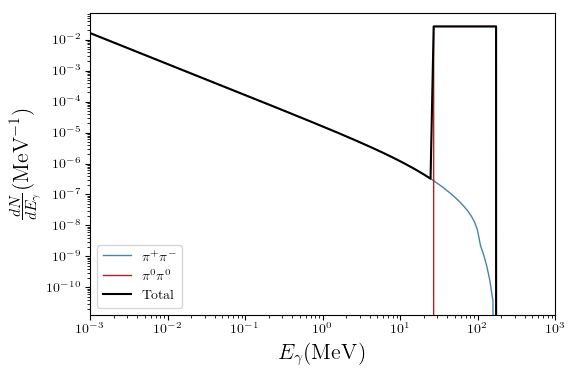

In [159]:
model = HazmaExample(200.0, 1.0, 1.0, 100e3)
egams = np.logspace(-3.0, 3.0, num=150)
vrel = 1e-3
Q = 2.0 * model.mx * (1 + 0.5 * vrel**2)
spectra = model.spectra(egams, Q)

plt.figure(dpi=100)
plt.plot(egams, spectra['pi pi'], label=r'$\pi^{+}\pi^{-}$', lw=1)
plt.plot(egams, spectra['pi0 pi0'], label=r'$\pi^{0}\pi^{0}$',lw=1)
plt.plot(egams, spectra['total'], label='Total', c='k')

plt.xlabel(r'$E_{\gamma} (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\frac{dN}{dE_{\gamma}} (\mathrm{MeV}^{-1})$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim([np.min(egams), np.max(egams)])
plt.legend()

In [170]:
mxs = np.linspace(mpi0, 250., num=100)
lims_e_astrogam = model.unbinned_limits(mxs, target_params=gc_target, bg_model=gc_bg_model)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/theory/_theory_gamma_ray_limits.py:341: RuntimeWarning: divide by zero encountered in double_scalars
  return prefactor * n_sigma / (-limit_obj.fun)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/theory/_theory_gamma_ray_limits.py:234: RuntimeWarning: invalid value encountered in sqrt
  df_de_a = 1. / np.sqrt(I_B_val) * \
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/theory/_theory_gamma_ray_limits.py:236: RuntimeWarning: invalid value encountered in sqrt
  df_de_b = -1. / np.sqrt(I_B_val) * \
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/theory/_theory_gamma_ray_limits.py:240: RuntimeWarning: invalid value encountered in sqrt
  return -I_S_val / np.sqrt(I_B_val), jac_val
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff

In [171]:
lims_e_astrogam

array([           inf, 1.42983520e-30, 1.48798944e-30, 1.55303243e-30,
       1.60550778e-30, 1.65976029e-30, 1.72051412e-30, 1.78621419e-30,
       1.86845401e-30, 1.90313207e-30, 1.98681111e-30, 2.01309408e-30,
       2.08761304e-30, 2.11783518e-30, 2.17697562e-30, 2.24261828e-30,
       2.30609385e-30, 2.36764711e-30, 2.42747658e-30, 2.48575309e-30,
       2.54270206e-30, 2.59849424e-30, 2.65323468e-30, 2.70700667e-30,
       2.75988146e-30, 2.81191573e-30, 2.86315868e-30, 2.91364668e-30,
       2.96341158e-30, 3.01548802e-30, 3.06361437e-30, 3.16017888e-30,
       3.20744821e-30, 3.25408154e-30, 3.30221739e-30, 3.39936100e-30,
       3.44434723e-30, 3.48870119e-30, 3.53401712e-30, 3.63185828e-30,
       3.67457618e-30, 3.71793979e-30, 3.81665608e-30, 3.85769154e-30,
       3.89907428e-30, 3.99865021e-30, 4.03791341e-30, 4.07724760e-30,
       4.17764604e-30, 4.21500702e-30, 4.25219202e-30, 4.35335697e-30,
       4.38945637e-30, 4.49159348e-30, 4.52616140e-30, 4.62978456e-30,
      

(134.9766, 250.0)

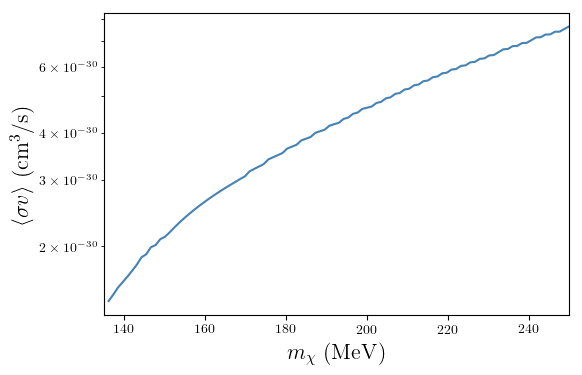

In [172]:
plt.figure(dpi=100)
plt.plot(mxs, lims_e_astrogam)
plt.yscale('log')
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$',fontsize=16)
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$',fontsize=16)
plt.xlim([np.min(mxs),np.max(mxs)])

In [142]:
model = HazmaExample(200.0, 1.0, 1.0, 100e3)
egams = np.logspace(-3.0, 3.0, num=150)
vrel = 1e-3
Q = 2.0 * model.mx * (1 + 0.5 * vrel**2)
spectra = model.spectra(egams, Q)

epos = np.logspace(np.log10(me), 3.0, num=150)
pos_spectra = model.positron_spectra(epos, Q)

Qs = np.logspace(np.log10(mpi/2), 250.)
bfs = [model.annihilation_branching_fractions(Q) for Q in Qs]

mxs = np.linspace(mpi/2., 250., num=100)
lims_e_astrogam = model.unbinned_limits(mxs, target_params=gc_target, bg_model=gc_bg_model)

/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/loganmorrison/.pyenv/versions/3.6.2/lib/python3.6/site-packages/hazma/theory/_th

In [ ]:
plt.figure(dpi=100)
for key, val in spectra.items():
    plt.plot(egams, val, label=key)

plt.xlabel(r'$E_{\gamma} (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\frac{dN}{dE_{\gamma}} (\mathrm{MeV}^{-1})$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.legend()

(0.510998928, 1000.0)

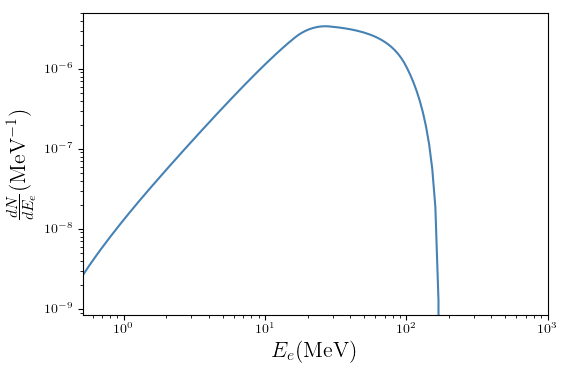

In [161]:
plt.figure(dpi=100)
plt.plot(epos, pos_spectra['pi pi'])
plt.xlabel(r'$E_{e} (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\frac{dN}{dE_{e}} (\mathrm{MeV}^{-1})$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim([np.min(epos),np.max(epos)])

In [173]:
def f(x):
    return x

In [174]:
f_vec = np.vectorize(f)

In [175]:
f_vec(1.0)

array(1.)